*Check the gradient boosting algorithm in section 10.10.2 of the book, [Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

## Core Hyperparameters in Gradient Boosting

1. **Number of Trees** (`n_estimators`)  
   - Use **early stopping** (via `n_iter_no_change` and `validation_fraction` in scikit-learn) to avoid overfitting.  
   - Start with a large value (e.g., 500–1000) and let early stopping prune unnecessary trees.

2. **Early Stopping**
   
   - Prevents overfitting by halting training once the validation performance stops improving.  
   - Controlled using:
     - `n_iter_no_change`: Number of rounds with no improvement before stopping (e.g., 10).
     - `validation_fraction`: Fraction of training data reserved as internal validation set (e.g., 0.1).
     - `tol`: Minimum improvement to be considered significant (e.g., `1e-4`).
   - Set a large `n_estimators`, and let early stopping determine the optimal number of boosting iterations.

3. **Learning Rate** (`learning_rate`)  
   - Shrinks the contribution of each tree to improve generalization.  
   - *Typical range*: 0.01–0.2 (lower values require more trees).

4. **Tree Complexity**
   - `max_depth`: Depth of individual trees. Start shallow (3–6) to limit overfitting.  
   - `min_samples_split`: Minimum samples required to split a node (e.g., 10–50).  
   - `min_samples_leaf`: Minimum samples required in a leaf node (e.g., 5–20).

5. **Stochastic Gradient Boosting**
   - `subsample`: Fraction of training data sampled per tree (e.g., 0.5–1.0).  
   - `max_features`: Fraction/absolute number of features used per split (e.g., `sqrt(n_features)` or `0.8`).

6. **Loss Function** (`loss`)
   
   - Matches the problem type:
     - Regression: `squared_error`, `absolute_error`
     - Classification: `log_loss` (binary/multinomial deviance)




In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import root_mean_squared_error, mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
import itertools as it
import time as time

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_convergence
import warnings
from IPython import display

Let’s reuse the car dataset to evaluate how different hyperparameter settings affect the performance of gradient boosting

In [13]:
# Load the dataset
car = pd.read_csv('Datasets/car.csv')
car.head()

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,vw,Beetle,2014,Manual,55457,Diesel,30,65.3266,1.6,7490
1,vauxhall,GTC,2017,Manual,15630,Petrol,145,47.2049,1.4,10998
2,merc,G Class,2012,Automatic,43000,Diesel,570,25.1172,3.0,44990
3,audi,RS5,2019,Automatic,10,Petrol,145,30.5593,2.9,51990
4,merc,X-CLASS,2018,Automatic,14000,Diesel,240,35.7168,2.3,28990


In [14]:
X = car.drop(columns=['price'])
y = car['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# extract the categorical columns and put them in a list
categorical_feature = X.select_dtypes(include=['object']).columns.tolist()

# extract the numerical columns and put them in a list
numerical_feature = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [15]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_encoded = encoder.fit_transform(X_train[categorical_feature])
X_test_encoded = encoder.transform(X_test[categorical_feature])

# Convert the encoded features back to DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_feature))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_feature))

# Concatenate the encoded features with the original numerical features
X_train_final = pd.concat([X_train_encoded_df, X_train[numerical_feature].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_encoded_df, X_test[numerical_feature].reset_index(drop=True)], axis=1)

### Effect of Number of Trees on Cross-Validation Error

Effect of Number of Trees on Cross-Validation Error
In Gradient Boosting, the number of trees (`n_estimators`) controls how many boosting rounds the model performs. Adding more trees can reduce bias and improve training accuracy, but it also increases the risk of overfitting, especially with a high learning rate.

The optimal number of trees is often found by balancing **model complexity** and **generalization performance** using cross-validation.

>2 14769.612 (563.444)
>5 12572.047 (567.992)
>10 10383.351 (555.641)
>50 6549.576 (722.462)
>100 5232.949 (656.216)
>500 3419.467 (262.753)
>1000 3106.002 (184.799)
>2000 3194.874 (293.134)
>5000 3272.374 (380.296)


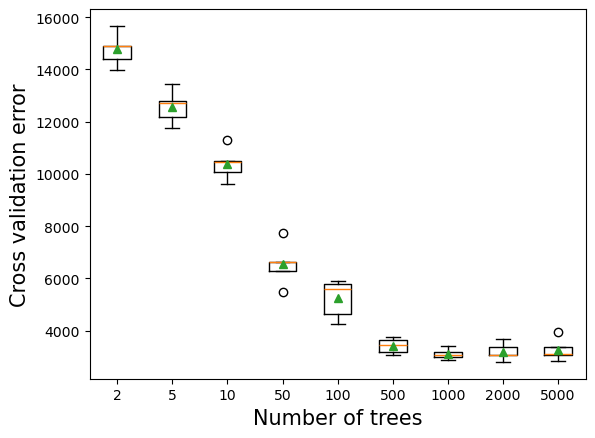

In [35]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [2, 5, 10, 50, 100, 500, 1000, 2000, 5000]
    for n in n_trees:
        models[str(n)] = GradientBoostingRegressor(n_estimators=n,random_state=1,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train_final, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15);

### Early stopping in Gradient Boosting 

**Early stopping** is a regularization technique used to prevent overfitting in boosting models. Instead of specifying a fixed number of trees (`n_estimators`), the algorithm monitors performance on a **validation set** and stops adding new trees once the model's improvement has plateaued.

In scikit-learn, early stopping can be enabled using:
- `early_stopping=True`
- `validation_fraction`: The fraction of training data used as a validation set
- `n_iter_no_change`: Number of iterations to wait without improvement before stopping

This approach not only improves generalization but also reduces training time by avoiding unnecessary trees.

In [ ]:
params = dict(n_estimators=2000, max_depth=5, learning_rate=0.1, random_state=42)

gbm_full = GradientBoostingRegressor(**params)
gbm_early_stopping = GradientBoostingRegressor(
    **params,
    validation_fraction=0.1,
    n_iter_no_change=10,
)

start_time = time.time()
gbm_full.fit(X_train_final, y_train)
training_time_full = time.time() - start_time
n_estimators_full = gbm_full.n_estimators_

start_time = time.time()
gbm_early_stopping.fit(X_train_final, y_train)
training_time_early_stopping = time.time() - start_time
estimators_early_stopping = gbm_early_stopping.n_estimators_

Let’s calculate the RMSE on both the training and test datasets for each model, which will be used for later visualization.

In [ ]:
# import root mean squared error function
from sklearn.metrics import root_mean_squared_error

train_errors_without = []
test_errors_without = []

train_errors_with = []
test_errors_with = []

for i, (train_pred, test_pred) in enumerate(
    zip(
        gbm_full.staged_predict(X_train_final),
        gbm_full.staged_predict(X_test_final),
    )
):
    train_errors_without.append(root_mean_squared_error(y_train, train_pred))
    test_errors_without.append(root_mean_squared_error(y_test, test_pred))

for i, (train_pred, test_pred) in enumerate(
    zip(
        gbm_early_stopping.staged_predict(X_train_final),
        gbm_early_stopping.staged_predict(X_test_final),
    )
):
    train_errors_with.append(root_mean_squared_error(y_train, train_pred))
    test_errors_with.append(root_mean_squared_error(y_test, test_pred))

Let's visulize Comparison. It includes three subplots:

1. Plotting training errors of both models over boosting iterations.
2. Plotting test errors of both models over boosting iterations.
3. Creating a bar chart to compare the training times and the number of estimators used by the models with and without early stopping.

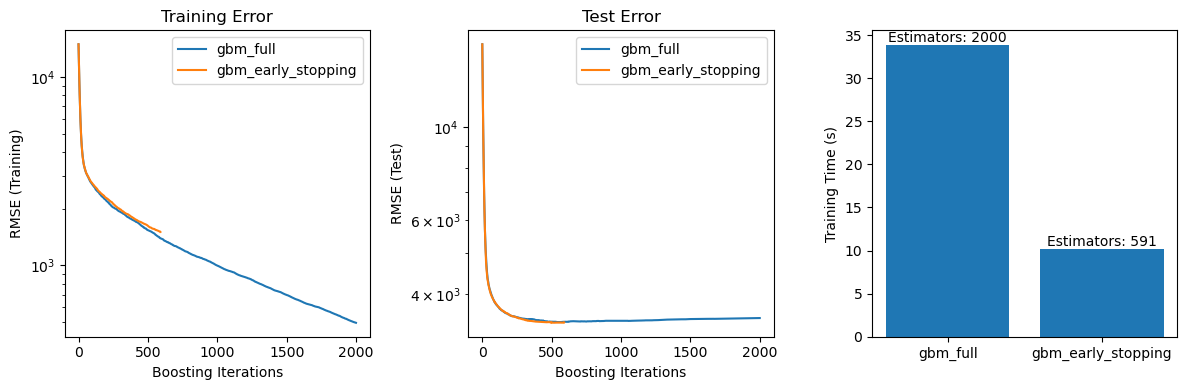

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

axes[0].plot(train_errors_without, label="gbm_full")
axes[0].plot(train_errors_with, label="gbm_early_stopping")
axes[0].set_xlabel("Boosting Iterations")
axes[0].set_ylabel("RMSE (Training)")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].set_title("Training Error")

axes[1].plot(test_errors_without, label="gbm_full")
axes[1].plot(test_errors_with, label="gbm_early_stopping")
axes[1].set_xlabel("Boosting Iterations")
axes[1].set_ylabel("RMSE (Test)")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].set_title("Test Error")

training_times = [training_time_full, training_time_early_stopping]
labels = ["gbm_full", "gbm_early_stopping"]
bars = axes[2].bar(labels, training_times)
axes[2].set_ylabel("Training Time (s)")

for bar, n_estimators in zip(bars, [n_estimators_full, estimators_early_stopping]):
    height = bar.get_height()
    axes[2].text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.001,
        f"Estimators: {n_estimators}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

The difference in training error between the `gbm_full` and the `gbm_early_stopping` stems from the fact that  
`gbm_early_stopping` sets aside `validation_fraction` of the training data as an internal validation set.  

Early stopping is decided based on this internal validation score.


**Benefits of Using Early Stopping in Boosting:**

- **Preventing Overfitting**  
  Early stopping helps avoid overfitting by monitoring the test error.  
  When the error stabilizes or starts increasing, training stops — resulting in better generalization to unseen data.

- **Improving Training Efficiency**  
  Models with early stopping often require **fewer estimators** while achieving similar accuracy.  
  This reduces training time significantly compared to training without early stopping.

### Effect of Learning Rate on Cross-Validation Error

The learning rate (`learning_rate`) determines how much each new tree contributes to the overall model. A **smaller learning rate** results in slower learning and often requires more trees to achieve good performance. A **larger learning rate** speeds up learning but increases the risk of overfitting.

Finding the optimal learning rate involves balancing:
- **High learning rate** → faster convergence, but higher risk of overfitting  
- **Low learning rate** → better generalization, but requires more trees and longer training time

Cross-validation helps identify the learning rate that minimizes prediction error while ensuring model stability.

>0.20 4193.7 (301.2)
>0.30 3740.3 (306.3)
>0.40 3630.0 (212.2)
>0.50 3529.6 (181.5)
>0.60 3650.2 (169.0)
>0.70 3644.7 (142.5)
>0.80 3908.9 (260.6)
>0.90 3968.7 (201.1)
>1.00 4208.3 (368.5)


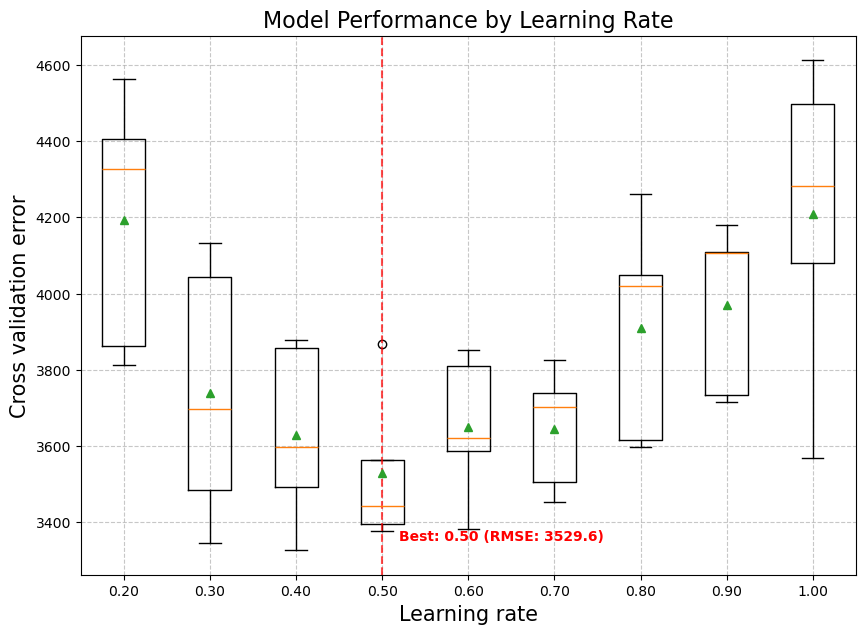


Best model: 0.50 with RMSE: 3529.563


In [ ]:
def get_models():
    models = dict()
    # create 9 evenly spaced values between 0.2 and 1.0
    learning_rates = np.linspace(0.2, 1.0, 9)
    for learning_rate in learning_rates:
        # Round to 2 decimal places for clean keys
        lr_rounded = round(learning_rate, 2)
        key = f"{lr_rounded:.2f}"
        models[key] = GradientBoostingRegressor(learning_rate=lr_rounded, random_state=1, loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
mean_scores = []  # Track mean scores separately

for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train_final, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # Calculate and store mean score
    mean_score = np.mean(scores)
    mean_scores.append(mean_score)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, mean_score, np.std(scores)))

# plot model performance for comparison
plt.figure(figsize=(10, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error', fontsize=15)
plt.xlabel('Learning rate', fontsize=15)
plt.title('Model Performance by Learning Rate', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Find the best model using the saved mean scores
best_index = np.argmin(mean_scores)
best_lr = names[best_index]
best_score = mean_scores[best_index]

# Highlight the best model on the plot
plt.axvline(x=best_index+1, color='red', linestyle='--', alpha=0.7)
plt.text(best_index+1.2, min(mean_scores)*0.95, 
         f'Best: {best_lr} (RMSE: {best_score:.1f})', 
         color='red', fontweight='bold')

plt.show()

# Print the best model information
print(f"\nBest model: {best_lr} with RMSE: {best_score:.3f}")


###  Learning Rate and Number of Trees Are Closely Linked

The **learning rate** and **number of trees** (`n_estimators`) are tightly coupled hyperparameters in gradient boosting. Their balance plays a key role in model performance and overfitting control.

- A **lower learning rate** slows the learning process, requiring **more trees** to achieve strong performance.
- A **higher learning rate** speeds up training but may cause the model to **overfit** if not regularized properly.

⚠️ A high learning rate with too few trees can lead to poor generalization, while a very low learning rate with too many trees may improve accuracy but increase training time significantly.

**Best practice:** Use a low to moderate learning rate (e.g., `0.01`–`0.1`) combined with **early stopping** to find the optimal number of trees.





### Effect of Stochastic Gradient Boosting on Cross-Validation Error

**Stochastic Gradient Boosting** enhances generalization by introducing randomness into the model-building process. Two key hyperparameters that control this are `subsample` and `max_features`, and they operate on **different dimensions** of the data:

| Parameter      | Applies To            | Purpose                                                                 |
|----------------|-----------------------|-------------------------------------------------------------------------|
| `subsample`    | Rows (data points)    | Randomly samples a fraction of the training data for each tree          |
| `max_features` | Columns (features)    | Randomly samples a fraction of the features for each tree or split      |

By tuning these parameters, we can reduce overfitting and increase model robustness. However, setting them too low may lead to underfitting due to insufficient information per tree.



In [ ]:
from sklearn.metrics import make_scorer, mean_squared_error

# Define model
model = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=1)

# Define param grid
param_grid = {
    'subsample': np.linspace(0.2, 1.0, 9),
    'max_features': np.linspace(0.2, 1.0, 9)
}

# RMSE scoring
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    scoring=scorer, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_final, y_train)

# Create DataFrame from results
results_df = pd.DataFrame(grid.cv_results_)
results_df['mean_rmse'] = np.sqrt(-results_df['mean_test_score'])


Fitting 5 folds for each of 81 candidates, totalling 405 fits


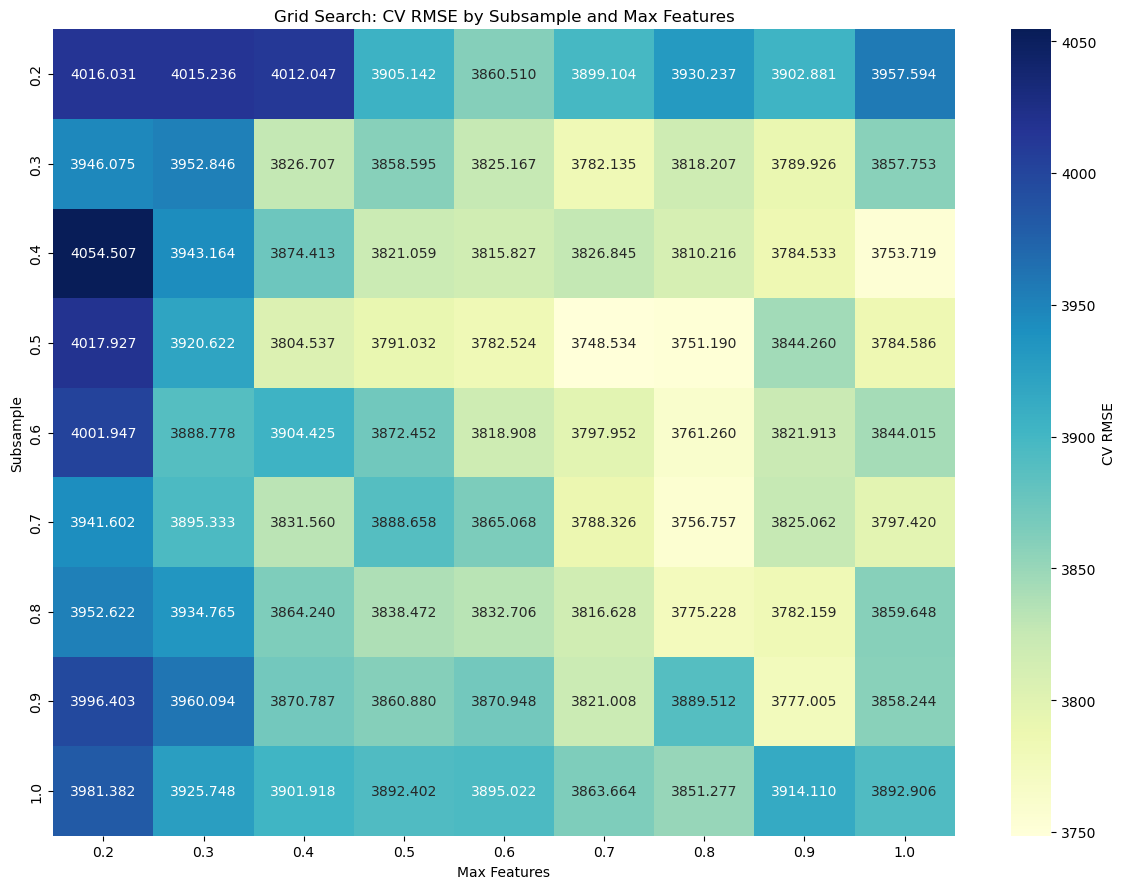

In [ ]:
# Round subsample and max_features to 2 decimal places for display
results_df['subsample'] = results_df['param_subsample'].astype(float).round(2)
results_df['max_features'] = results_df['param_max_features'].astype(float).round(2)

# Then pivot using the rounded values
heatmap_data = results_df.pivot(index='subsample', columns='max_features', values='mean_rmse')

# Plot heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'CV RMSE'})
plt.title('Grid Search: CV RMSE by Subsample and Max Features')
plt.ylabel('Subsample')
plt.xlabel('Max Features')
plt.tight_layout()
plt.show()

### Effect of Tree Complexity on Cross-Validation Error (Not Tuned Here)

**Tree complexity** controls how expressive and flexible each individual tree in the gradient boosting ensemble can be. While deeper and more complex trees can capture intricate patterns in the data, they are also more prone to overfitting, especially when combined with many trees.

Key parameters include:

- `max_depth`: Limits the depth of each tree. Shallower trees (e.g., depth 3–6) are preferred for reducing overfitting.
- `min_samples_split`: Specifies the minimum number of samples required to split an internal node. Higher values make the tree more conservative.
- `min_samples_leaf`: Sets the minimum number of samples required to be at a leaf node. This also helps smooth the model and avoid capturing noise.

These parameters influence the bias-variance trade-off by adjusting how expressive each tree can be.

Since we have already discussed and tuned these parameters in earlier lessons (decision trees and random forests), we will **not tune them again here**. 

### Loss Function (`loss`)

In gradient boosting, the loss function determines how the model measures prediction errors and guides the optimization process during training. Here’s a breakdown of common loss functions for regression and classification tasks:

- **Regression**:
  - `squared_error`: Penalizes larger errors more heavily; sensitive to outliers. *(Default for regression)*
  - `absolute_error`: Penalizes all errors equally; more robust to outliers.
  - `huber`: Combines squared and absolute error; less sensitive to outliers than `squared_error` and smoother than `absolute_error`.

- **Classification**:
  - `log_loss`: Also known as logistic loss or deviance; commonly used for binary and multiclass classification.
  - `exponential`: Used by AdaBoost; heavily penalizes misclassified points, making it more sensitive to outliers.


Choosing an appropriate loss function ensures the model is optimized for the specific structure and goals of the problem.

## Joint Hyperparameter Tuning in Gradient Boosting for Regression

Since the optimal values of hyperparameters are often interdependent, they should be tuned **together** rather than in isolation to achieve the best performance.

### Using `BayesSearchCV`

We can use `BayesSearchCV` with early stopping to **simultaneously tune multiple hyperparameters** in a more efficient and automated way.

In [27]:
# time the search
start = time.time()
# Define the search space
search_space = {
    'learning_rate': Real(0.01, 0.8, prior='log-uniform'),  # Prefer lower rates
    'max_depth': Integer(4, 32),          # Shallow trees to prevent overfitting
    'min_samples_split': Integer(2, 100), # Regularize splits
    'min_samples_leaf': Integer(1, 30),  # Regularize leaves
    'subsample': Real(0.1, 1.0),         # Stochastic sampling
    'max_features': Categorical([
        'sqrt', 'log2', None,  # String options
        0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  # Fractional options (discrete)
    ])  # Feature sampling
}

# Define the model
model_with_early_stopping = GradientBoostingRegressor(
    n_estimators=10000,  # Start with a large number of trees
    validation_fraction=0.1,  # Reserve 10% of training data for validation
    n_iter_no_change=10,      # Stop after 20 rounds of no improvement
    tol=0.001,           # Tolerance for early stopping
    random_state=42
)
# Define the search
bayes_cv  = BayesSearchCV(
    model_with_early_stopping,
    search_space,
    n_iter=50,  # Number of iterations
    scoring='neg_mean_squared_error',
    cv=5,  # Cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Verbosity level
    random_state=42  # For reproducibility
)
# Fit the model
bayes_cv.fit(X_train_final, y_train)
# Stop the timer
end = time.time()
# Calculate elapsed time
elapsed_time = (end - start)/60  # Convert to minutes
# Print elapsed time
print(f"Elapsed time for Bayesian optimization with early stopping: {elapsed_time:.2f} minutes")

# Extract the best parameters and score
best_params = bayes_cv.best_params_
best_score = np.sqrt(-bayes_cv.best_score_)

print(f"Best Parameters: {best_params}")
print(f"Best CV RMSE: {best_score:.3f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

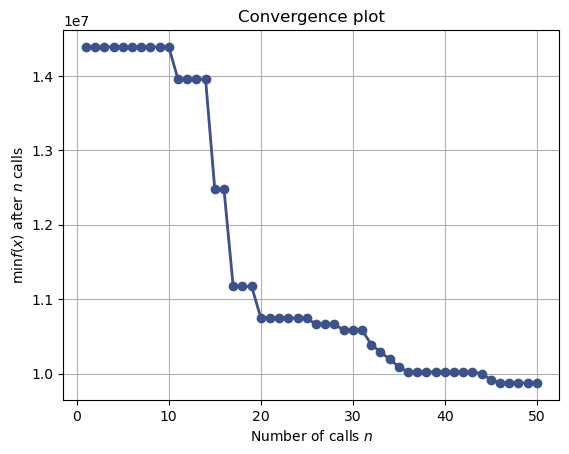

In [28]:
# Plot the optimization results
plot_convergence(bayes_cv.optimizer_results_);

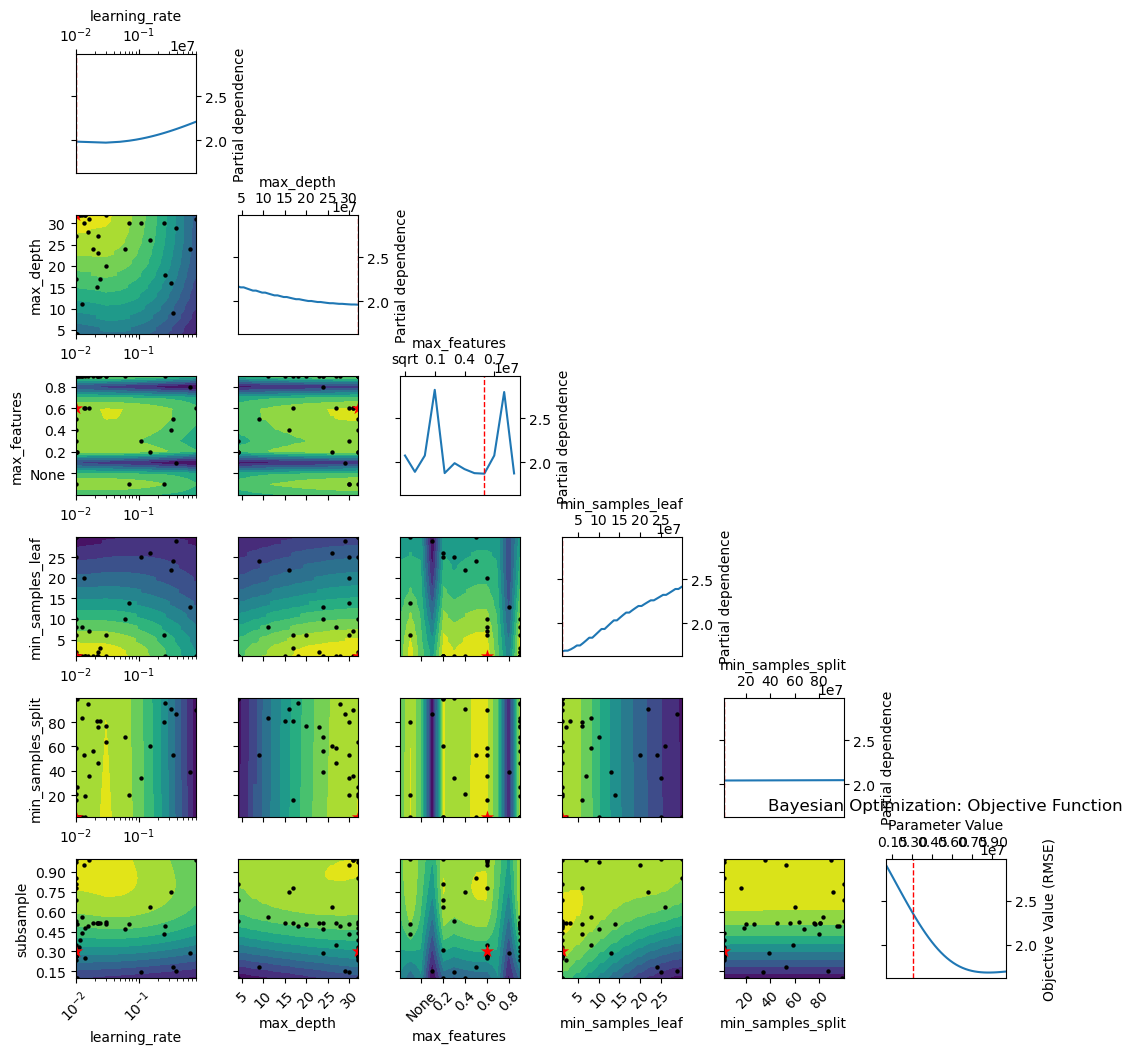

In [29]:
# Plot the objective function
plot_objective(bayes_cv.optimizer_results_[0])
plt.title('Bayesian Optimization: Objective Function')
plt.xlabel('Parameter Value')
plt.ylabel('Objective Value (RMSE)')
plt.show()


### Tuning with Optuna

In [30]:
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.8, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'max_features': trial.suggest_categorical(
            'max_features', 
            ['sqrt', 'log2', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        ),
        'n_iter_no_change': 10,  # Stop if no improvement in 50 rounds
        'validation_fraction': 0.1,  # 10% of training data for validation
        'tol': 0.001,  # Tolerance for early stopping
        'n_estimators': 10000,  # Start with a large number of trees
        'random_state': 42
    }

    # Initialize the model with the parameters, adding early stopping
    model = GradientBoostingRegressor(
        **params
    )
    model = GradientBoostingRegressor(**params)
    # Define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # Perform cross-validation
    scores = cross_val_score(model, X_train_final, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    return np.mean(np.sqrt(-scores)) 


In [31]:
import optuna
start = time.time()
# Create a study object
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=600)  # 50 trials or 10 min
# Stop the timer
end = time.time()
# Calculate elapsed time
elapsed_time = (end - start)/60  # Convert to minutes
print(f"Elapsed time for Optuna optimization: {elapsed_time:.2f} minutes")
# Extract the best parameters and score
best_params_optuna = study.best_params
best_score_optuna = study.best_value
print(f"Best Parameters: {best_params_optuna}")
print(f"Best CV RMSE: {best_score_optuna:.3f}")

[I 2025-05-06 17:02:10,428] A new study created in memory with name: no-name-a137b8c9-3b60-46c9-a520-903b610148de
[I 2025-05-06 17:02:29,091] Trial 0 finished with value: 3713.7523573640283 and parameters: {'learning_rate': 0.02248358344580717, 'max_depth': 14, 'min_samples_split': 84, 'min_samples_leaf': 10, 'subsample': 0.9198945421607535, 'max_features': 0.8}. Best is trial 0 with value: 3713.7523573640283.
[I 2025-05-06 17:02:30,785] Trial 1 finished with value: 4709.295547981693 and parameters: {'learning_rate': 0.021255444625248174, 'max_depth': 12, 'min_samples_split': 44, 'min_samples_leaf': 7, 'subsample': 0.1707682907352387, 'max_features': 0.4}. Best is trial 0 with value: 3713.7523573640283.
[I 2025-05-06 17:02:31,180] Trial 2 finished with value: 6213.951571057093 and parameters: {'learning_rate': 0.257260645216299, 'max_depth': 16, 'min_samples_split': 51, 'min_samples_leaf': 28, 'subsample': 0.254712411062096, 'max_features': 'log2'}. Best is trial 0 with value: 3713.752

Elapsed time for Optuna optimization: 4.55 minutes
Best Parameters: {'learning_rate': 0.022878117048627775, 'max_depth': 23, 'min_samples_split': 27, 'min_samples_leaf': 3, 'subsample': 0.6772149662412676, 'max_features': 'log2'}
Best CV RMSE: 3205.359


In [32]:
optuna.visualization.plot_optimization_history(study).show()

In [33]:
optuna.visualization.plot_param_importances(study).show()

In [34]:
optuna.visualization.plot_parallel_coordinate(study).show()

## Scaling Gradient Boosting for Large Datasets and Smarter Tuning

Check out [`HistGradientBoostingRegressor()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) and [`HistGradientBoostingClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) for a faster gradient boosting algorithm for big datasets *(more than 10,000 observations)*.

Check out tips for faster hyperparameter tuning, such as tuning `max_leaf_nodes` instead of `max_depth` [here](https://scikit-learn.org/stable/modules/ensemble.html#controlling-the-tree-size).

##  Independent Study

In this notebook, we used the car dataset for a guided regression task to illustrate the core hyperparameters in gradient boosting and how to tune them to balance bias and variance.

For your practice, please work with the **diabetes dataset** and complete the following:

- Fit a baseline gradient boosting classifier.
- Tune key hyperparameters: `learning_rate`, `n_estimators`, `max_depth`, and `subsample`.
- Use **early stopping** to determine the optimal number of trees.
- Compare training and test `roc_auc` before and after tuning.
- Visualize the learning curve (training vs test error across iterations).
- Summarize what combination of hyperparameters yielded the best performance and how they impacted bias and variance.

Feel free to use `GridSearchCV`, `BayesSearchCV`, or other tuning as you prefer.


In [37]:
train = pd.read_csv('./Datasets/diabetes_train.csv')
test = pd.read_csv('./Datasets/diabetes_test.csv')

In [39]:
print(train.shape, test.shape)
train.head()

(614, 9) (154, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,88,74,19,53,29.0,0.229,22,0
1,2,129,84,0,0,28.0,0.284,27,0
2,0,102,78,40,90,34.5,0.238,24,0
3,0,123,72,0,0,36.3,0.258,52,1
4,1,144,82,46,180,46.1,0.335,46,1


In [41]:
# check the distribution of the target variable
train['Outcome'].value_counts(normalize=True)


Outcome
0    0.662866
1    0.337134
Name: proportion, dtype: float64